# Use Autoencoder to implement anomaly detection on credit card dataset

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42  # smae value yenar parat run keli ki
LABELS = ["Normal", "Fraud"]

In [10]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [11]:
df.shape

(271287, 31)

In [12]:
df.isnull().values.any()

True

In [13]:
print(list(df.columns))
df.describe()

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,271287.000000,271287.000000,271287.000000,271287.000000,271287.000000,271287.000000,271287.000000,271287.000000,271287.000000,271286.000000,...,271286.000000,271286.000000,271286.000000,271286.000000,271286.000000,271286.000000,271286.000000,271286.000000,271286.000000,271286.000000
mean,91155.782997,-0.007911,-0.012544,0.037657,0.008088,-0.014794,0.006591,-0.006754,-0.000098,-0.000008,...,-0.000183,-0.003791,-0.001803,0.000707,0.007352,0.000474,-0.000280,0.000520,89.312745,0.001773
std,45665.591916,1.957297,1.654705,1.510347,1.415854,1.366703,1.324929,1.219117,1.191942,1.103040,...,0.736956,0.722706,0.629697,0.605759,0.518715,0.483535,0.398944,0.331816,247.442292,0.042070
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,52708.000000,-0.922523,-0.606529,-0.829439,-0.846258,-0.706913,-0.761364,-0.558836,-0.206504,-0.648336,...,-0.226946,-0.538606,-0.162888,-0.352713,-0.308339,-0.328185,-0.070686,-0.052066,5.930000,0.000000
50%,81338.000000,0.018481,0.059971,0.226369,-0.006704,-0.071539,-0.265137,0.031820,0.024150,-0.053146,...,-0.029966,0.004253,-0.013531,0.042728,0.029703,-0.054781,0.001629,0.012150,22.580000,0.000000
75%,134832.500000,1.297184,0.790260,1.055733,0.762272,0.593872,0.407336,0.560634,0.327050,0.601508,...,0.182979,0.517718,0.143614,0.436915,0.355581,0.243362,0.089781,0.077854,78.720000,0.000000
max,164505.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.877368,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


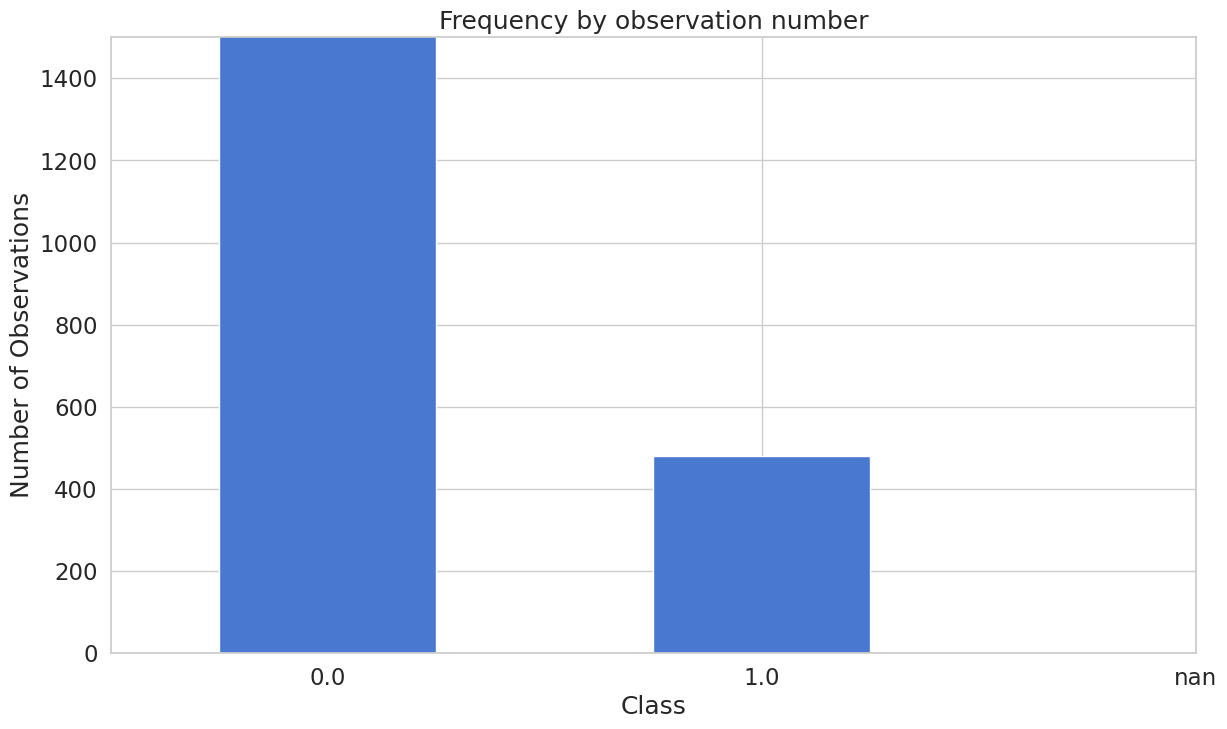

In [14]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df['Class'].unique())), df.Class.unique())
plt.title("Frequency by observation number")
plt.ylim(0,1500)
plt.xlabel("Class")
plt.ylabel("Number of Observations");

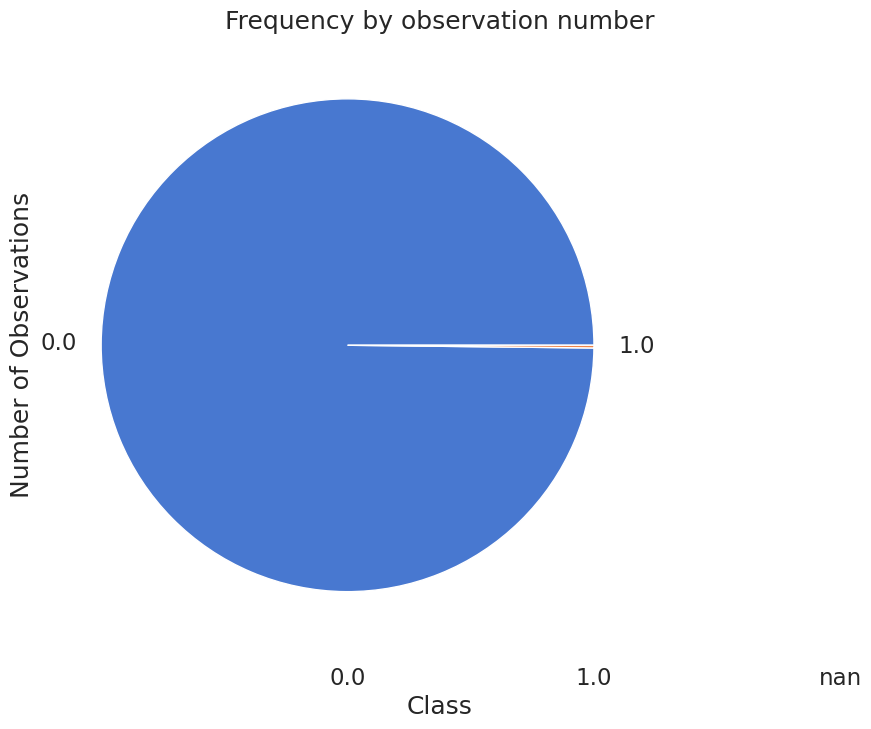

In [15]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'pie', rot=0)
plt.xticks(range(len(df['Class'].unique())), df.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [16]:
sc=StandardScaler()
df['Time'] = sc.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = sc.fit_transform(df['Amount'].values.reshape(-1, 1))

In [17]:
raw_data = df.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2021)

In [18]:
#'''Normalize the data to have a value between 0 and 1'''
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [19]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 372
 No. of records in Normal Train data= 216657
 No. of records in Fraud Test Data= 110
 No. of records in Normal Test data= 54148


In [20]:
raw_data = df.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2021)

In [21]:
# Normalize the data to have a value between 0 and 1
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [23]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14   # 14 neurons in dense layers
hidden_dim_1 = int(encoding_dim / 2) # first hidden layer che no. of neuron count karte
hidden_dim_2=4                       # second hidden layer has 4 neurons
learning_rate = 1e-7

### c) Encoder converts it into latent representation

In [24]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))  # reduce dimension of input
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

### d) Decoder networks convert it back to the original

In [25]:
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)   # combine the encoder and decoder
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [26]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",mode='min', monitor='val_loss', verbose=2, save_best_only=True)

In [27]:
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

In [28]:
#Compile the Autoencoder

autoencoder.compile(metrics=['accuracy'],
loss='mean_squared_error',

optimizer='adam')

#Train the Autoencoder
history = autoencoder.fit(normal_train_data, normal_train_data,
epochs=nb_epoch,
batch_size=batch_size,
shuffle=True,

validation_data=(test_data, test_data),
verbose=1,

callbacks=[cp, early_stop]
).history

Epoch 1/50
3384/3386 [============================>.] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 1: val_loss did not improve from inf
3386/3386 [==============================] - 14s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/50
3369/3386 [============================>.] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 2: val_loss did not improve from inf
3386/3386 [==============================] - 11s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/50
3373/3386 [============================>.] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 3: val_loss did not improve from inf
3386/3386 [==============================] - 11s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/50
3386/3386 [==============================] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 4: val_loss did not improve from inf
3386/3386 [==============================] - 11s 3ms/step - loss

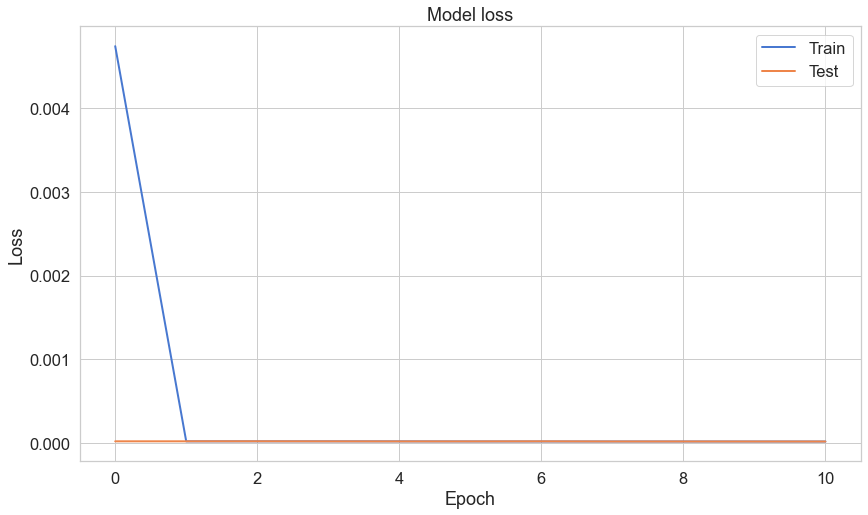

In [ ]:
#Plot training and test loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
'True_class': test_labels})

1781/1781 [==============================] - 1s 606us/step


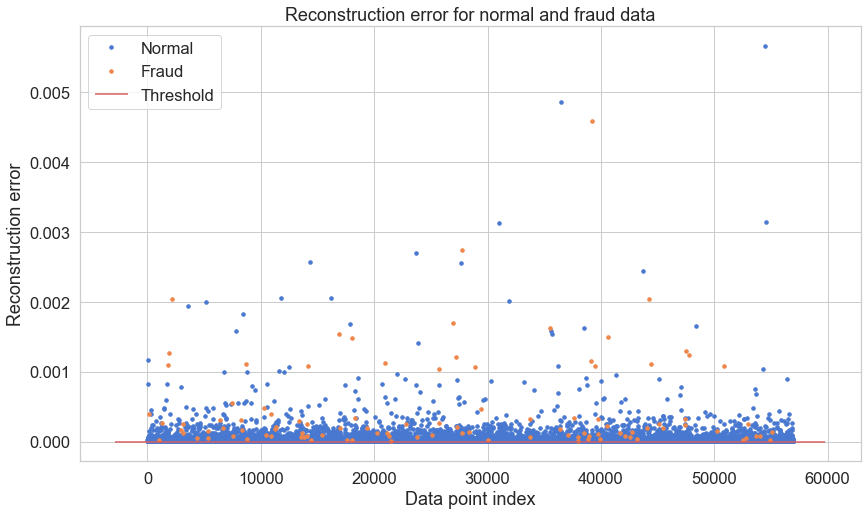

In [ ]:
threshold_fixed = 0
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

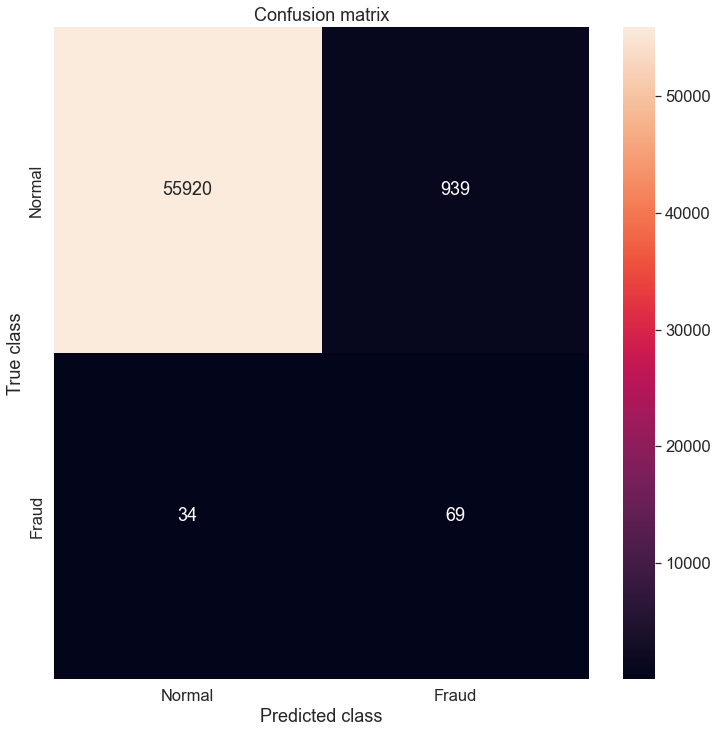

In [ ]:
threshold_fixed = 0.0001
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()